In [56]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, KFold, validation_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
sns.set_style("darkgrid", {'axes.grid' : False})

In [57]:
iris = load_iris()
df = pd.DataFrame(iris.data)
df['label'] = iris.target
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']
labels = {index: name for index, name in enumerate(iris.target_names)}
df['label'] = df['label'].map(labels)
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,label
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


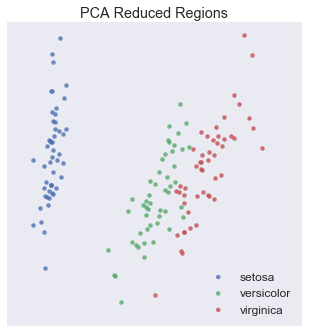

In [58]:
pca = PCA(n_components=2)
reduced = pca.fit(iris.data, iris.target).transform(iris.data)
reduced_df = pd.DataFrame(reduced)
reduced_df['label'] = iris.target
reduced_df.columns = ['PCA1', 'PCA2', 'label']
fg = sns.lmplot('PCA1', 'PCA2', data=reduced_df, hue='label', fit_reg=False, legend=False)
fg.set(ylim=[-1.5, 1.5])
fg.fig.suptitle('PCA Reduced Regions', size='x-large', x=0.55, y=.9998)
fg.ax.legend(labels=iris.target_names, loc='lower right', fontsize='large')
fg.ax.set_xticks([]) 
fg.ax.set_yticks([])
fg.ax.set_xlabel('')
fg.ax.set_ylabel('')

/Users/chase/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


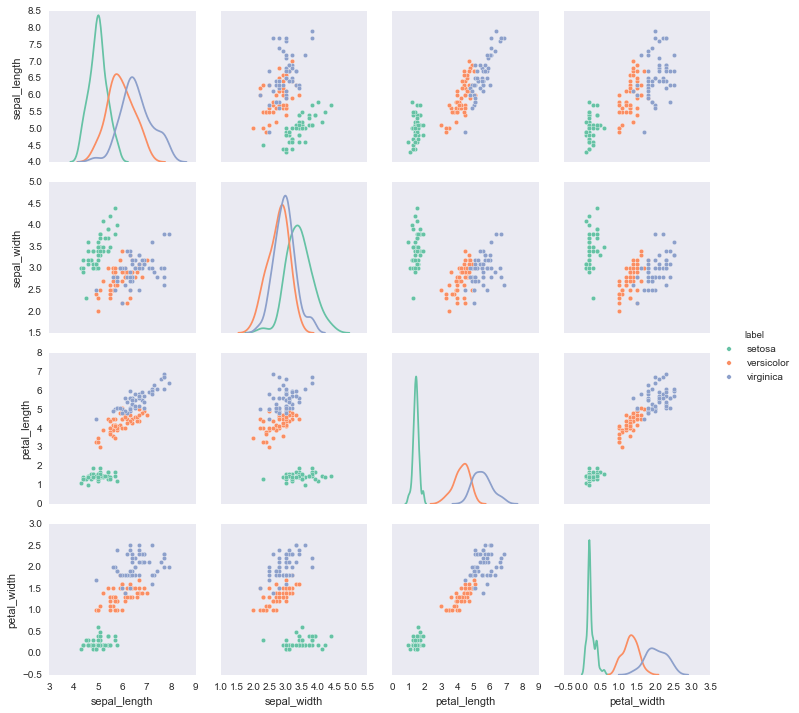

In [59]:
g = sns.pairplot(df, hue="label", palette="Set2", diag_kind="kde", size=2.5)

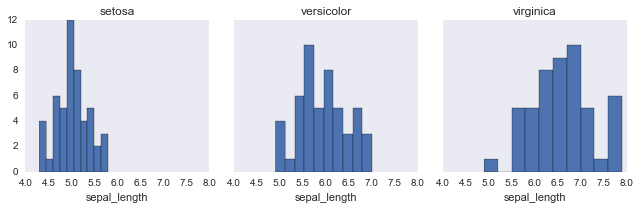

In [60]:
g = sns.FacetGrid(df, col='label')
g.map(plt.hist, 'sepal_length')
for ax, title in zip(g.axes.flat, iris.target_names):
    ax.set_title(title)

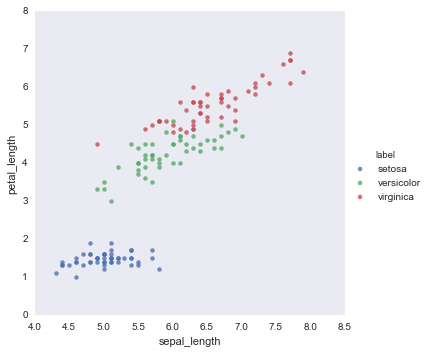

In [61]:
sns.lmplot('sepal_length', 'petal_length', data=df, fit_reg=False, hue='label')

In [62]:
X = df.iloc[:, :4].values
y = iris.target
loo = LeaveOneOut()
def test_model(clf, name):
    scores = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(clf.score(X_test, y_test))
    print(name + ' Accuracy: %.1f%%' % (np.mean(scores) * 100))


In [63]:
log = LogisticRegression()
test_model(log, 'Logistic Regression')

dtc = DecisionTreeClassifier()
test_model(dtc, 'Decision Tree Classifier')

lda = LinearDiscriminantAnalysis()
test_model(lda, 'Linear Discriminant Analysis')

Logistic Regression Accuracy: 95.3%
Decision Tree Classifier Accuracy: 94.7%
Linear Discriminant Analysis Accuracy: 98.0%


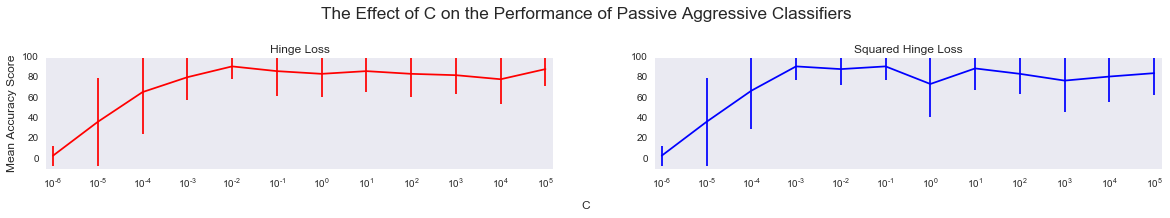

In [64]:
groups = 10
seed = 11
pa_1 = PassiveAggressiveClassifier(loss='hinge', n_iter=100)
pa_2 = PassiveAggressiveClassifier(loss='squared_hinge', n_iter=100)
kfold = KFold(n_splits=groups, random_state=seed)
param_range = np.logspace(-6, 5, 12)

def model_validation_curve(model, color, ax, title):
    train_scores, test_scores = validation_curve(
        model, X, y, param_name="C", param_range=param_range,
        cv=kfold, scoring="accuracy", n_jobs=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.errorbar(param_range, test_scores_mean * 100, yerr=test_scores_std * 100, c=color,
                capsize=0)
    ax.set_title(title, size='large')
    ax.set_xscale('log')
    ax.set_xlim([7.0e-7, 1.5e5])
    ax.set_ylim([-10, 100])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 2))
model_validation_curve(pa_1, 'r', ax1, 'Hinge Loss')
model_validation_curve(pa_2, 'b', ax2, 'Squared Hinge Loss')

ax1.set_ylabel('Mean Accuracy Score', size='large')
fig.text(0.5, -.15, 'C', ha='center', size='large')

plt.suptitle('The Effect of C on the Performance of Passive Aggressive Classifiers', size='xx-large', y=1.25)
plt.show()

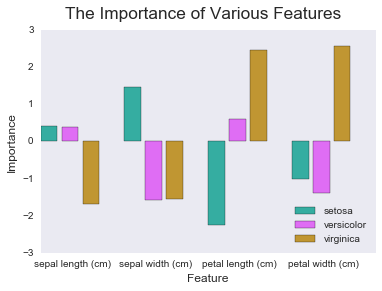

In [65]:
x_axis = np.array(list(range(0, 15, 4)))
colors = sns.husl_palette(3, h=.5)

rectangles = []
fig, ax = plt.subplots()
for index, (coef, color) in enumerate(zip(log.coef_, colors)):
    rectangles.append(ax.bar(x_axis + index, coef, color=color)[0])

labels = []
for name in iris.feature_names:
    labels.append(name)

ax.set_xticks(x_axis + 1.5)
ax.set_xticklabels(labels, horizontalalignment='center', size='medium')

plt.xlabel('Feature', size='large')
plt.ylabel('Importance', size='large')
plt.suptitle('The Importance of Various Features', size='xx-large')
plt.legend(rectangles, iris.target_names, loc=4)
plt.show()